# Imports

In [2]:
import gzip
import pickle

import platform 
from random import choice
import scipy.stats
import sys
import gi
from gi.repository import Gtk, Gdk
import graph_tool.all as gt
import graph_tool as graph_tool
import pandas as pd
import numpy as np
import os
# move to repo root folder
os.chdir('/data_clear/alberto/projects/decentralization/decentralization/')
# os.chdir('../')
import sys
sys.path.insert(0, os.path.join(os.getcwd(),"utils"))
from hsbm import sbmmultilayer 
# from hsbm.utils.nmi import * 
from hsbm.utils.doc_clustering import construct_nmi_matrix # *
# from hsbm_creation import *
# from hsbm_fit import *
# from hsbm_partitions import *

import time
from tqdm.notebook import tqdm

from sklearn.feature_extraction import text
from nltk.stem import  WordNetLemmatizer
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime

import random
import seaborn as sn

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from IPython.display import display

In [724]:
# DEFAULT PARAMETERS IN THE FIGURES TO BE ADJUSTED!!!!

plt.style.use("default")

height_fig = 5
width_fig = 10

params_default = {
    # no upper and right axes
    'axes.spines.right' : False,
    'axes.spines.top' : False,
    # no frame around the legend
    "legend.frameon" : False,

    # dimensions of figures and labels
    # we will play with these once we see how they are rendered in the latex
    'figure.figsize' : (width_fig, height_fig),

    'axes.labelsize' : 22,
    'axes.titlesize' : 25,
    'xtick.labelsize' : 18,
    'ytick.labelsize' : 18,
    'legend.fontsize' : 16,
    
    
    # no grids (?)
    'axes.grid' : False,

    # the default color(s) for lines in the plots: in order if multiple lines. We can change them or add colors if needed
#     'axes.prop_cycle' : mpl.cycler(color=["#00008B", "#BF0000", "#006400"]), 

    # default quality of the plot. Not too high but neither too low
    "savefig.dpi" : 300,
    "savefig.bbox" : 'tight', 
    
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    
}


plt.rcParams.update(params_default)

In [4]:
class print_color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
def split_words(string):
    words = []
    word_tmp = ""
    for letter in string:
        if letter in "QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm":
            word_tmp += letter
        else:
            words.append(word_tmp)
            words.append(letter)
            word_tmp = ""
    if letter in "QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm":
        words.append(word_tmp)
    return words

# Loading data

In [6]:
corpus_version = '2022-01-01' # '2021-09-01' '2022-01-01'
all_dataset_path = f"data/{corpus_version}/"
dataset_path = f"data/{corpus_version}/decentralization/"
paper_figures_folder = f"figures/"

In [7]:
filter_label = '' # if you want a specific label to do some testing
min_inCitations = 0
min_word_occurences = 5
use_titles = True

In [8]:
results_folder = os.path.join(dataset_path,f'{min_inCitations}_min_inCitations_{min_word_occurences}_min_word_occurrences/')

chosen_text_attribute = 'paperAbstract'
if use_titles:
    # USE TITLES TEXT INSTEAD OF ABSTRACTS
    print('Using titles text instead of abstracts!', flush=True)
    chosen_text_attribute = 'title'
    results_folder = results_folder[:-1] + '_titles/'
prep_results_folder = results_folder

# results_folder += 'ID_1_no_iterMC_5000/'
results_folder += 'consensus_all_100_iter/'

Using titles text instead of abstracts!


## all_docs

In [9]:
print('Loading data')
with gzip.open(f"{dataset_path}papers_dict.pkl.gz", "rb") as fp:
    all_docs_dict = pickle.load(fp)

Loading data


In [10]:
all_docs_dict['a00017fee08f765c31ad7d80d87ddf0d88e2f352'].keys()

dict_keys(['id', 'title', 'paperAbstract', 'authors', 'inCitations', 'outCitations', 'year', 's2Url', 'sources', 'pdfUrls', 'venue', 'journalName', 'journalVolume', 'journalPages', 'doi', 'doiUrl', 'pmid', 'fieldsOfStudy', 'magId', 's2PdfUrl', 'entities'])

## tokenized abstracts

In [11]:
with gzip.open(f"{prep_results_folder}tokenized_texts_dict_all.pkl.gz", "rb") as fp:
    tokenized_texts_dict = pickle.load(fp)

# Fig 1 - papers in year

In [12]:
with gzip.open(all_dataset_path+"no_papers_in_fields_by_year.pkl.gz","rb") as fp:
    papers_per_year_per_field = pickle.load(fp)
    
with gzip.open(all_dataset_path+"no_authors_in_fields_by_year.pkl.gz","rb") as fp:
    authors_per_year_per_field = pickle.load(fp)
    
    
try:
    with gzip.open(all_dataset_path+"no_authors_by_year.pkl.gz","rb") as fp:
        no_authors_per_year = pickle.load(fp)
except Exception as e:
    print(e)
    with gzip.open(all_dataset_path+"sets_authors_in_fields_by_year.pkl.gz","rb") as fp:
        set_authors_per_year_per_field = pickle.load(fp)
     
    no_authors_per_year = {}
    for year in set_authors_per_year_per_field.keys():
        no_authors_per_year[year] = len(set().union(*list(set_authors_per_year_per_field[year].values())))
                                        
    with gzip.open(all_dataset_path+"no_authors_by_year.pkl.gz","wb") as fp:
        pickle.dump(no_authors_per_year,fp)  

In [13]:
years = sorted([x for x in papers_per_year_per_field.keys() if x is not None and x > 1500])

set_authors_per_year_decentralization = {y:set() for y in years}
for paper in all_docs_dict.values():
    if paper['year'] is not None:
        set_authors_per_year_decentralization[paper['year']].update([aut['ids'][0] for aut in paper['authors'] if paper['authors'] is not None and len(paper['authors'])>0 and len(aut['ids'])>0])
        
no_authors_per_year_decentralization = {y:len(set_authors_per_year_decentralization[y]) for y in years}

In [13]:
# FIGURE 2x2 OLD

# xlims = (1950,2021)
# fs = 20
# y_small = 1.02
# x_small = 0.05

# fig,axes = plt.subplots(2,2,figsize = (16,8),gridspec_kw={'wspace':0.3,'hspace':0.25})

# ax = axes[0][0]
# # ax.set_title("Fraction of decentralization papers in the full academic literature")
# dec_papers = pd.Series([x['year'] if 'year' in x else None for x in all_docs ]).explode().value_counts().sort_index()

# all_papers = pd.Series(index=years,data=[sum(list(papers_per_year_per_field[x].values())) for x in years])

# ax.plot(dec_papers.index,dec_papers.values,label='(De)centralization')
# ax.plot(all_papers.index,all_papers.values,label='ALL papers')

# ax.set_xlim(xlims)
# ax.set_yscale("log")
# ax.set_ylim((1,10**8))
# ax.set_ylabel("number of papers")
# ax.legend()
# ax.text(s="(a)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')




# ax = axes[1][0]
# # ax.set_title("Fraction of decentralization papers in the full academic literature")

# dec_papers = pd.Series([x['year'] if 'year' in x else None for x in all_docs ]).explode().value_counts().sort_index()

# all_papers = pd.Series(index=years,data=[sum(list(papers_per_year_per_field[x].values())) for x in years])

# frac_papers = dec_papers.align(all_papers,fill_value=0)[0]/dec_papers.align(all_papers,fill_value=0)[1]
# ax.plot(frac_papers.index,frac_papers.values, color = 'red')

# ax.set_xlim(xlims)
# ax.set_yscale("log")
# ax.set_ylim((10**(-4),2*10**(-2)))
# ax.set_ylabel("fraction of papers")

# ax.axvline(2016,linestyle='--',color='grey',lw=2, label='New Growth')
# ax.axvline(1963,linestyle='--',color='green',lw=2, label='Start Growth')
# ax.axvline(2008,linestyle='--',color='black',lw=2, label='Bitcoin whitepaper')# ax.legend()

# ax.text(s="(b)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')
# ax.legend()




# ax = axes[0][1]
# # ax.set_title("Fraction of decentralization papers in the full academic literature")
# dec_authors = pd.Series(no_authors_per_year_decentralization).sort_index()
# all_authors = pd.Series(no_authors_per_year).sort_index()


# ax.plot(dec_authors.index,dec_authors.values,label='(De)centralization')
# ax.plot(all_authors.index,all_authors.values,label='ALL papers')

# ax.set_xlim(xlims)
# ax.set_ylim((1,10**8))
# ax.set_yscale("log")
# ax.set_ylabel("number of authors")
# # ax.legend()
# ax.text(s="(c)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')




# ax = axes[1][1]
# # ax.set_title("Fraction of decentralization papers in the full academic literature")


# frac_authors = dec_authors.align(all_authors,fill_value=0)[0]/dec_authors.align(all_authors,fill_value=0)[1]
# ax.plot(frac_authors.index,frac_authors.values, color = 'red')

# ax.set_xlim(xlims)
# ax.set_yscale("log")
# ax.set_ylim((10**(-4),2*10**(-2)))
# ax.set_ylabel("fraction of authors")


# ax.text(s="(D)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')



# fig.savefig(f"{paper_figures_folder}figure_1.pdf")

/home/enterprise.internal.city.ac.uk/aczy350/anaconda3/envs/gt/lib/python3.9/site-packages/pandas/core/indexes/base.py:3706: RuntimeWarning: '<' not supported between instances of 'NoneType' and 'int', sort order is undefined for incomparable objects
  join_index = self.union(other)


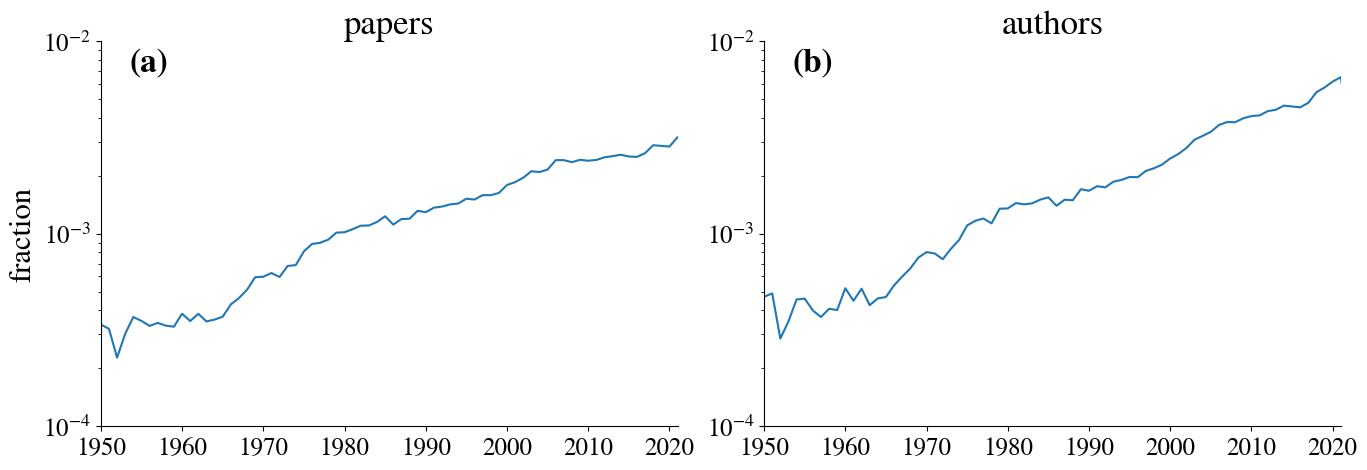

In [192]:
xlims = (1950,2021)
fs = 24
y_small = .92
x_small = 0.05

upper_limit = 10*10**(-3)
fig,axes = plt.subplots(1,2,figsize = (16,5),gridspec_kw={'wspace':0.15})

ax = axes[0]
# ax.set_title("Fraction of decentralization papers in the full academic literature")

dec_papers = pd.Series([x['year'] if 'year' in x else None for x in all_docs_dict.values()]).explode().value_counts().sort_index()

all_papers = pd.Series(index=years,data=[sum(list(papers_per_year_per_field[x].values())) for x in years])

frac_papers = dec_papers.align(all_papers,fill_value=0)[0]/dec_papers.align(all_papers,fill_value=0)[1]
ax.plot(frac_papers.index,frac_papers.values)#, color = 'red')

ax.set_xlim(xlims)
ax.set_xticks(range(1950,2022,10))
ax.set_yscale("log")
ax.set_ylim((10**(-4),upper_limit))
ax.set_ylabel("fraction")
ax.set_title("papers")

# ax.axvline(2016,linestyle='--',color='grey',lw=2, label='New Growth')
# ax.axvline(1963,linestyle='--',color='green',lw=2, label='Start Growth')
# ax.axvline(2008,linestyle='--',color='black',lw=2, label='Bitcoin whitepaper')# ax.legend()

ax.text(s="(a)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')
# ax.legend()





ax = axes[1]
# ax.set_title("Fraction of decentralization papers in the full academic literature")
dec_authors = pd.Series(no_authors_per_year_decentralization).sort_index()
all_authors = pd.Series(no_authors_per_year).sort_index()


frac_authors = dec_authors.align(all_authors,fill_value=0)[0]/dec_authors.align(all_authors,fill_value=0)[1]
ax.plot(frac_authors.index,frac_authors.values)#, color = 'red')

ax.set_xlim(xlims)
ax.set_yscale("log")
ax.set_ylim((10**(-4),upper_limit))
# ax.set_ylabel("fraction")
ax.set_xticks(range(1950,2022,10))
ax.set_title("authors")

ax.text(s="(b)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')



fig.savefig(f"{paper_figures_folder}figure_1.pdf")

# graph-tool analysis

- texts: list of tokenized abstracts
- titles: list of unique paperIds


In [14]:
filter_label = ""# "_filtered_%dcits"%(min_citations)
print(filter_label)

In [15]:
hyperlink_g = gt.load_graph(f"{prep_results_folder}gt_network{filter_label}.gt")
num_vertices = hyperlink_g.num_vertices()
num_edges = hyperlink_g.num_edges()
print(num_vertices, num_edges)

181605 590215


In [16]:
label = hyperlink_g.vp["label"]
name = hyperlink_g.vp["name"] # every vertex has a name already associated to it!

# Retrieve true partition of graph
true_partition = list(hyperlink_g.vp.label)    
# Retrieve ordering of articles
article_names = list(hyperlink_g.vp.name)

# unique_hyperlinks = hyperlinks.copy()

In [17]:
try:
    with gzip.open(f"{prep_results_folder}IDs_texts_and_edited_text_papers_with_abstract{filter_label}.pkl.gz", "rb") as fp:
        IDs,texts,edited_text = pickle.load(fp)
except:
    with gzip.open(f"{prep_results_folder}titles_texts_and_edited_text_papers_with_abstract{filter_label}.pkl.gz", "rb") as fp:
        IDs,texts,edited_text = pickle.load(fp)

## Load states

In [20]:
# results_folder = results_folder
# start = datetime.now()
# print("Doing analysis, not fit",flush = True)
# results_folder = results_folder + f"ID_{_id_list[0]}_no_iterMC_{number_iterations_MC_equilibrate}_edge_divider_{edge_divider}/"
# with gzip.open(f"{results_folder}/results_fit_greedy{filter_label}.gz","rb") as fp:
#             hyperlink_text_hsbm_states,time_duration = pickle.load(fp)
# print("Loaded %d"%_id_list[0],flush = True)


# for _id in _id_list[1:]:
#     results_folder = results_folder + f"ID_{_id}_no_iterMC_{number_iterations_MC_equilibrate}_edge_divider_{edge_divider}/"
#     with gzip.open(f"{results_folder}/results_fit_greedy{filter_label}.gz","rb") as fp:
# #                 hyperlink_text_hsbm_states.append(pickle.load(fp)[0])
#             hyperlink_text_hsbm_states += pickle.load(fp)[0]
#     print("Loaded %d"%_id,flush = True)
# end = datetime.now()
# print("Time laoding states",end-start,flush=True)
# with gzip.open(f"{results_folder}/results_fit_greedy{filter_label}.gz","wb") as fp:
#     pickle.dump((hyperlink_text_hsbm_states,end-start),fp)
# results_folder = results_folder

In [ ]:
with gzip.open(f"{results_folder}results_fit_greedy{filter_label}.pkl.gz","rb") as fp:
    hyperlink_text_hsbm_states,time_duration = pickle.load(fp)

In [ ]:
print(time_duration,flush=True)

In [23]:
x = list(hyperlink_g.vertices())
y = list(hyperlink_text_hsbm_states[0].g.vertices())
x == y

False

In [28]:
int(x[100])

100

In [36]:
hyperlink_g.vp["name"][list(hyperlink_g.vertices())[0]]

'b91626a4613926f9644005c73b5d3a078cc0df99'

In [32]:
ordered_paper_ids = list(hyperlink_g.vp['name'])
ordered_paper_ids2 = list(hyperlink_text_hsbm_states[0].g.vp['name'])
ordered_paper_ids3 = list(hyperlink_text_hsbm_states[1].g.vp['name'])
ordered_paper_ids2 == ordered_paper_ids3

True

In [31]:
ordered_paper_ids[:10], ordered_paper_ids2[:10]

(['b91626a4613926f9644005c73b5d3a078cc0df99',
  'd61cdfcb1a41ece17f950f969738d96cb6c88b01',
  '312ec4498b246e5cfc7ac3fd28cfb90ed9041731',
  '1c072c06467a00c946c1a572dcd487c4c1f6236c',
  'd4c8cedb943daf61c8f221d32996f520591befda',
  '4705879fbe9083383c0ba5e4c7049b8ede3b6dd9',
  'c105845a5c1138c6f75b749397604925f1a03b59',
  '2e176f96e1ce63ee700ffba93f6f5921b5c1c1cf',
  'afc271fdbb95ea7cd45f9feb722801e755464fd3',
  '8ebff39102ceae8602bf52f45b59a2e329a7514f'],
 ['bb2225c0b034afe13dc52b66a9e9a9c1dda3e187',
  'd9b54e145f0d274e020ffd7e042e8b6b2b5d79c2',
  '5f55be182c0542c063249fb2bb2c29d91fa4f988',
  '38d6adbc6ec1b913adf2041231ba0603d08a0cb3',
  'e681fd90193ae81dc9c742088181e599b59b3115',
  '9ea8b176aee954aff982b766debfe73143d0fbcb',
  '09a3fa1c27feb4649545d4ae2e74af3f0bd41821',
  'bde48d2a35fb47f66325116129945923bf55a8e5',
  'dd2881feb964f871a21cc8c3f0ab8cda175f8ba6',
  '80bd329d0fbd9343221566f61020e2f9fed916d1'])

In [20]:
print(len(hyperlink_text_hsbm_states[0].documents),flush=True)

NameError: name 'hyperlink_text_hsbm_states' is not defined

## Retrieve partitions

Retrieve the partitions assigned to the document nodes by examining the highest non-trivial level of the hierarchical degree-corrected SBM.

In [18]:
with gzip.open(f"{results_folder}results_fit_greedy_partitions{filter_label}.pkl.gz","rb") as fp:
    hyperlink_text_hsbm_partitions, levels = pickle.load(fp)
    # Retrieve partitions assigned to documents in each run. Also save index of highest non-trivial level.

In [19]:
print(levels)

[5, 5, 5, 5, 6, 5, 6, 5, 4, 5, 5, 7, 5, 5, 6, 5, 5, 7, 5, 5, 6, 5, 6, 5, 6, 5, 6, 7, 5, 5, 6, 5, 5, 6, 5, 6, 6, 5, 6, 8, 5, 5, 6, 6, 5, 6, 5, 6, 5, 5, 5, 7, 6, 5, 6, 5, 4, 6, 5, 5, 6, 5, 6, 6, 5, 5, 6, 5, 5, 5, 5, 6, 6, 4, 6, 5, 5, 6, 4, 7, 5, 5, 5, 7, 6, 4, 5, 7, 5, 7, 6, 5, 6, 6, 5, 5, 5, 7, 7, 7]


## Compute centralities

In [410]:
try:
    with gzip.open(f'{prep_results_folder}hyperlink_g_centralities{filter_label}.pkl.gz','rb') as fp:
        centralities = pickle.load(fp)
except:
    print("Calculating centralities...")
    ordered_paper_ids = list(hyperlink_g.vp['name'])
    id2NoCits = {x: len(all_docs_dict[x]['inCitations']) for x in all_docs_dict.keys()}

    centralities = {}
    centralities['citations_overall'] = np.vectorize(id2NoCits.get)(ordered_paper_ids)
    print("Done citations_overall centrality", flush=True)
    citations_df = pd.read_csv(f"{prep_results_folder}citations_edgelist.csv")
    paper_with_cits = citations_df['from'].value_counts().index.values
    paper_without_cits = set(ordered_paper_ids).difference(set(paper_with_cits))
    centralities['in_degree'] = citations_df['from'].value_counts().append(pd.Series(data = np.zeros(len(paper_without_cits)),index=paper_without_cits)).loc[ordered_paper_ids].values
    print("Done in_degree centrality", flush=True)
    if len(ordered_paper_ids) > 1000:
        centralities['eigenvector'] = graph_tool.centrality.eigenvector(hyperlink_g)[1]._get_data()
        print("Done eigenvector centrality", flush=True)
    centralities['betweenness'] = graph_tool.centrality.betweenness(hyperlink_g)[0]._get_data()
    print("Done betweenness centrality", flush=True)
    centralities['closeness'] = graph_tool.centrality.closeness(hyperlink_g)._get_data()
    print("Done closeness centrality", flush=True)
    centralities['pagerank'] = graph_tool.centrality.pagerank(hyperlink_g)._get_data()
    print("Done pagerank centrality", flush=True)
    centralities['katz'] = graph_tool.centrality.katz(hyperlink_g)._get_data()
    print("Done katz centrality", flush=True)

    with gzip.open(f'{prep_results_folder}hyperlink_g_centralities{filter_label}.pkl.gz','wb') as fp:
        pickle.dump(centralities,fp)

In [414]:
[i for i,x in enumerate(ordered_paper_ids) if 'clarification' in all_docs_dict[x]['title']]

[3086, 49968, 75487, 148758, 159490, 178130]

In [419]:
centralities['out_degree'][3086]

552.0

In [421]:
len(all_docs_dict[ordered_paper_ids[3086]]['inCitations'])

13287

## Consensus Partition

Compute the consensus partition assignment to document nodes over all the runs.

In [21]:
print("loading")
with gzip.open(f"{results_folder}results_fit_greedy_partitions_docs_all{filter_label}.pkl.gz","rb") as fp:
    hyperlink_text_hsbm_partitions_by_level,duration = pickle.load(fp)
# with gzip.open(f"{results_folder}results_fit_greedy_partitions_docs_all_info{filter_label}.pkl.gz","rb") as fp:
#     hyperlink_text_hsbm_partitions_by_level_info,duration = pickle.load(fp)

loading


In [22]:
with gzip.open(f"{results_folder}/results_fit_greedy_partitions_consensus_all{filter_label}.pkl.gz","rb") as fp:
    h_t_doc_consensus_by_level, h_t_word_consensus_by_level, h_t_consensus_summary_by_level = pickle.load(fp)


In [23]:
ordered_paper_ids = list(hyperlink_g.vp['name'])

In [24]:
# WORKS WITH MORE THAN 1 ITERATION (in teoria va bene sempre...)
name2partition_by_level = {max(list(h_t_doc_consensus_by_level.keys()))+1 : {x:0 for x in ordered_paper_ids}}

for level in h_t_doc_consensus_by_level.keys():
    name2partition_by_level[level] = {}
    for i,paper_id in enumerate(list(hyperlink_g.vp["name"])):
        name2partition_by_level[level][paper_id] = h_t_doc_consensus_by_level[level][i]

In [25]:
# # WORKS WITH ONLY 1 ITERATION
# name2partition_by_level = {}

# for level in hyperlink_text_consensus_partitions_by_level.keys():
#     name2partition_by_level[level] = hyperlink_text_hsbm_partitions_by_level_info[level][0][3]

# ## ALERT this works only if one iteration has been done, otherwise fix it

In [26]:
doc_partition_remapping_by_level = {}
doc_partition_remapping_by_level_inverse = {}
for level in name2partition_by_level:
    if level != max(list(h_t_doc_consensus_by_level.keys()))+1:
        # level = 3
        doc_partition_remapping_by_level[level] = {}
        doc_partition_remapping_by_level_inverse[level] = {}
        lista1 = []
        for paper in ordered_paper_ids:
            lista1.append(name2partition_by_level[level][paper])
    #     lista2 = hyperlink_text_consensus_partitions_by_level[level]
        lista2 = h_t_doc_consensus_by_level[level]
    #     print(set(list(zip(lista1,lista2))))
        for part1, part2 in set(list(zip(lista1,lista2))):
            if part1 in doc_partition_remapping_by_level[level]:
                print("THERE ARE MULTIPLE INSTANCES... ERROR")
                break
            else:
                doc_partition_remapping_by_level[level][part1] = part2  
                doc_partition_remapping_by_level_inverse[level][part2] = part1

### Project level

#### Loading it

In [ ]:
initial_level = 3
with open(results_folder+f"model_consensus_occ_{occ}_initial_level_{initial_level}.pkl","rb") as fp:
    model = pickle.load(fp)
state = model.state

In [ ]:
state = model.state
print(state,"\n")
levels = state.get_levels()
for i,s in enumerate(levels):
    print(i,s)
    if s.get_N() == 1:
        break

In [ ]:
state.print_summary()

#### Creation projected state

We now retrieve the topics associated to the consensus partition of Hyperlink + Text model.

In [ ]:
initial_level = 3

In [ ]:
with gzip.open(f"{results_folder}results_fit_greedy_partitions_words_all{filter_label}.gz","rb") as fp:
    H_T_word_hsbm_partitions_by_level, H_T_word_hsbm_num_groups_by_level = pickle.load(fp)

In [ ]:
# h_t_doc_consensus = gt.partition_overlap_center(hyperlink_text_hsbm_partitions)[0]
# h_t_doc_consensus_by_level = {l:gt.partition_overlap_center(hyperlink_text_hsbm_partitions_by_level[l])[0] for l in hyperlink_text_hsbm_partitions_by_level.keys()}

In [ ]:
model=hyperlink_text_hsbm_states[0]
print(model)

In [ ]:
state = model.state
print(state,"\n")
levels = state.get_levels()
for i,s in enumerate(levels):
    print(i,s)
    if s.get_N() == 1:
        break

In [ ]:
state.print_summary()

In [ ]:
def get_consensus_nested_partition_bs(h_t_word_consensus_by_level):
    """
    As parameter it takes a dictionary {level: [[partition[paper] for paper in papers] for i in iterations]}.
    It calculates the nested consensus partition (reordered correctly)
    """
    hierarchy_words_partitions = {}
    for l in range(max(h_t_word_consensus_by_level),0,-1):
        tmp1_words, tmp2_words = h_t_word_consensus_by_level[l], h_t_word_consensus_by_level[l-1]


        hierarchy_words_partitions[l] = {w: set() for w in np.unique(tmp1_words)}

        for i in range(len(tmp1_words)):
            hierarchy_words_partitions[l][tmp1_words[i]].add(tmp2_words[i])

    hyperlink_words_hsbm_partitions_by_level = {0:h_t_word_consensus_by_level[0]}

    for l in range(1,len(h_t_word_consensus_by_level)):
        
        tmp_list = -np.ones(int(max(hyperlink_words_hsbm_partitions_by_level[l-1])+1),dtype=int)
        for i,group in hierarchy_words_partitions[l].items():
            for j in group:
                tmp_list[j] = i
        hyperlink_words_hsbm_partitions_by_level[l] = tmp_list

    bs_w = [hyperlink_words_hsbm_partitions_by_level[l] for l in hyperlink_words_hsbm_partitions_by_level.keys()]
    return bs_w

In [ ]:
# bs_w = get_consensus_nested_partition_bs(h_t_word_consensus_by_level)
# If you want less levels, just use the following
bs_w = get_consensus_nested_partition_bs({level-initial_level:partition for level,partition in h_t_word_consensus_by_level.items() if level >= initial_level})

In [ ]:
bs_w[-1]

In [ ]:
for l in range(len(bs_w)):
    bs_w[l] = bs_w[l][bs_w[l] != -1]

In [ ]:
bs_w.append(np.ones(len(set(bs_w[-1])),dtype=int))

In [ ]:
bs_w.append(np.array([0]))

In [ ]:
# bs_d = get_consensus_nested_partition_bs(h_t_doc_consensus_by_level)
# If you want less levels, just use the following
# initial_level = 2
bs_d = get_consensus_nested_partition_bs({level-initial_level:partition for level,partition in h_t_doc_consensus_by_level.items() if level >= initial_level})

In [ ]:
bs_d[-1]

In [ ]:
bs_d.append(np.zeros(len(set(bs_d[-1])),dtype=int))

In [ ]:
bs_d.append(np.array([0]))

In [ ]:
ordered_paper_ids = list(hyperlink_g.vp['name'])
new_ordered_partitions_dict = {}
for i,v in tqdm(enumerate(model.g.vertices())):
    if model.g.vp["kind"][v] == 0:
        paper_id = model.g.vp['name'][v]
        new_ordered_partitions_dict[paper_id] = ordered_paper_ids.index(paper_id)

In [ ]:
l = initial_level
new_ordered_partitions = []
for i,v in tqdm(enumerate(model.g.vertices())):
    if model.g.vp["kind"][v] == 0:
        paper_id = model.g.vp['name'][v]
        new_ordered_partitions.append(h_t_doc_consensus_by_level[l][new_ordered_partitions_dict[paper_id]])
bs_d[0] = np.array(new_ordered_partitions)

In [ ]:
bs = []
for l in range(len(bs_d)):
    bs.append(np.concatenate((bs_d[l],bs_w[l])))

In [ ]:
state = model.state.copy(bs=bs)

In [ ]:
# lowest = model.state.project_level(2)

In [ ]:
# model.state.levels[0] = lowest

In [ ]:
# del model.state.levels[1:3]
# model.state.levels

In [ ]:
# model.state.levels[0].layer_states

In [ ]:
state.print_summary()

In [ ]:
model.state = state

In [ ]:
model.n_levels = len(model.state.levels)

In [ ]:
groups = {}
groups = { level: model.get_groupStats(l=level) for level in tqdm(range(model.n_levels - 2)) }

In [ ]:
model.groups = groups

In [ ]:
with open(results_folder+f"model_consensus_occ_{occ}_initial_level_{initial_level}.pkl","wb") as fp:
    pickle.dump(model,fp)

In [ ]:
with open(results_folder+f"state_consensus_occ_{occ}_initial_level_{initial_level}.pkl","wb") as fp:
    pickle.dump(state,fp)

#### Get top elements in each cluster

In [ ]:
# check group membership
level = 0
count = 0
for i in range(len(model.groups[level]["p_td_d"][0])):
    if np.sum(model.groups[level]["p_td_d"][:,i]) not in {0,1}:
        if np.isnan(np.sum(model.groups[level]["p_td_d"][:,i])):
            count += 1
        else:
            print(i, sum(model.groups[level]["p_td_d"][:,i]))
            break
print("There are %d nan"%count)
# at level 1 (new) there are 380 nan in docs, 0 in words

In [ ]:
group_membership = {}
partitions = {-i-1:set() for i in range(model.groups[level]['Bw'])} # words have negative topic index here
for i in range(model.groups[level]['Bd']):
    partitions[i] = set() # documents  have positive topic index here
N_docs = model.get_D()
for v in model.g.vertices():
    if model.g.vp["kind"][v] == 0: # is document
        tmp = np.where(model.groups[level]["p_td_d"][:,int(v)] == 1)
        is_word = False
    else:
        tmp = np.where(model.groups[level]["p_tw_w"][:,int(v)-N_docs] == 1)
        is_word = True
    if len(tmp) == 0 or len(tmp[0]) == 0:
        group_membership[v] = -1
    else:
        if is_word:
            group_membership[v] = - tmp[0][0]
            partitions[- tmp[0][0] - 1].add(v)
        else:
            group_membership[v] = tmp[0][0]
            partitions[tmp[0][0]].add(v)
        

In [ ]:
# just a check here
min_d = 100000000
max_d = -1
min_w = 100000000
max_w = -1
for i,v in enumerate(model.g.vertices()):
    if model.g.vp["kind"][v] == 0:
        min_d = min(min_d,int(v))
        max_d = max(max_d,int(v))
    else:
        min_w = min(min_w,int(v))
        max_w = max(max_w,int(v))

min_d, max_d, min_w, max_w

In [ ]:
for i,j in partitions.items():
    if len(partitions[i]) > 0:
        if i>= 0 and max(partitions[i]) >= N_docs:
            print(i,min(partitions[i]), max(partitions[i]))
        elif i< 0 and min(partitions[i]) < N_docs:
            print(i,min(partitions[i]), max(partitions[i]))

In [ ]:
g = model.g

In [ ]:
degrees = g.degree_property_map("total")

In [ ]:
highest_degree_in_partitions = {}
for i,j in partitions.items():
    max_degree = -1
    max_v = -1
    for v in j:
        if degrees[v] > max_degree:
            max_v = v
            max_degree = degrees[v]
    if max_v != -1:
        highest_degree_in_partitions[i] = max_v

In [ ]:
text_position = model.g.new_vp("double")
for v in model.g.vertices():
    if model.g.vp["kind"][v] == 0:
        text_position[v] = 0
    else:
        text_position[v] = np.pi

In [ ]:
def split_in_rows(string, max_lines = 3, max_chars_in_line = 18):
    new_string = ""
    count = 0
    count_lines = 1
    for char in string:
#         print(char)
        if count > max_chars_in_line:
            if count_lines == max_lines:
                return new_string
            else:
                new_string += "\n"
                count_lines += 1
            if char != " ":
                new_string += char
                count = 1
            else:
                count = 0
        elif max_chars_in_line - count < 3 and char == " ":
            if count_lines == max_lines:
                return new_string
            else:
                new_string += "\n"
                count_lines += 1
                count = 0
        else:
            new_string += char
            count += 1
    return new_string

In [ ]:
text_nodes = model.g.new_vp("string")
for v in model.g.vertices():
    text_nodes[v] = ""
for i,v in highest_degree_in_partitions.items():
#     print(int(v))
    if i >= 0:
#         text_nodes[v] = model.documents[int(v)]
        text_nodes[v] = all_docs_dict[model.documents[int(v)]]["title"]
#         text_nodes[v] = split_in_rows(all_docs_dict[model.documents[int(v)]]["title"], max_lines=5,max_chars_in_line=8)
#         text_nodes[v] = model.documents[int(v)] # use ... np.array(model.get_topicProportion(0,l=0))
    else:
        text_nodes[v] = model.words[int(v)-N_docs]

In [ ]:
text_font_size = model.g.new_vp("int")
for v in model.g.vertices():
    text_font_size[v] = 10
for i,v in highest_degree_in_partitions.items():
    if i >= 0:
        text_font_size[v] = 6

#### Other useful functions
These are not actually used in the rest of the notebook

In [ ]:
np.array(model.get_topicProportion(0,l=0))

In [ ]:
query = model.clusters_query(1878, l=4)

In [ ]:
query[:10]

In [ ]:
model.get_topics(l=4,n=5)

In [ ]:
model.get_topicProportion([1800,1801],l=4)

In [ ]:
# For some reason, this does not work. Needs to be checked in sbmmultilayer.py
model.get_docclusters(l=4,n=10)

#### Plotting

In [ ]:
middle = state.project_level(1)

In [ ]:
blocks_middle = middle.get_blocks()

In [ ]:
blocks_list = list(set(blocks_middle))
N = len(blocks_list)
tmp_palette = sn.color_palette("bright", N) # husl , inferno, bright, colorblind

In [ ]:
tmp_palette

In [ ]:
palette = tmp_palette

In [ ]:
# REORDER PALETTE FOR BETTER VISIONING
# ACHTUNG: works only with initial_layer = 3
indexes_to_add = {2,4,6,8,10,11,12} # These are the indexes in  palette that are picked for documents
to_add = [3,4,5,8,9,10,12] # choose instead these colours
not_to_add = list(set(range(N)).difference(set(to_add)))

palette = []
for i in range(N):
    if i in indexes_to_add:
        palette.append(tmp_palette[to_add[0]])
        del to_add[0]
    else:
        palette.append(tmp_palette[not_to_add[0]])
        del not_to_add[0]

In [ ]:
N

In [ ]:
set(blocks_list)

In [ ]:
colors = {}
for i,block in enumerate(blocks_list):
    colors[block] = [1, *palette[i], 0.1]

colors2 = {}
for i,block in enumerate(blocks_list):
#     colors2[block] = [1, *palette[i], 0.1]
    colors2[block] = [*palette[i]]

In [ ]:
g = model.g

v_size = g.new_vp("double")

degrees = g.degree_property_map("total")

In [ ]:
for v in g.vertices():
    v_size[v] = 2*np.log(degrees[v])

In [ ]:
color_vertices = g.new_vp("vector<double>")

for v in g.vertices():
    color_vertices[v] = colors2[blocks_middle[v]] # [0, 0.68041891, 0.61514975, 0.19405452, 1]# 

In [ ]:
color_edges = g.new_ep("vector<double>")

for e in g.edges():
    source,target = e
#     source_kind = g.vp["kind"][source]
#     target_kind = g.vp["kind"][target]
    color_edges[e] = colors[blocks_middle[source]] # [0, 0.68041891, 0.61514975, 0.19405452, 1]# 

In [ ]:
pos, h, hpos = state.draw(
#     output=paper_figures_folder+"bipartite_cut_levels_6-2.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices, "text":text_nodes, "text_position":text_position}, 
    subsample_edges = 100, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":5,"gradient":color_edges},
    hvprops = {"size":15, "pen_width":2,"color":"blue", "text":"123", "text_color":"black","font_size":20},
    heprops = {"pen_width":6},
    layout = "bipartite",
    bip_aspect = 1)

In [ ]:
pos, h, hpos = state.draw(
#     output=paper_figures_folder+"bipartite_cut_levels_6-2.png", 
    bg_color='w',
    output_size=(1920, 1200),
#     vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices, "text":text_nodes, "test_position":test_position}, 
    subsample_edges = 100, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
#     vsize_scale = 100,
    eprops = {"pen_width":5},#,"gradient":color_edges},
    hvprops = {"size":15, "pen_width":2,"color":"blue", "text":"123", "text_color":"black","font_size":20},
    heprops = {"pen_width":6},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
n = model.get_V() + model.get_D()

In [ ]:
hv_names = h.new_vp("string")
for v in h.vertices():
    hv_names[v] = str(int(v)-n)

In [ ]:
hv_pos = h.new_vp("double")
hv_offset = h.new_vp("double") # IT GIVES RUNTIME ERROR! :(
for v in h.vertices():
    if hpos[v][0] > 0:
        hv_pos[v] = 0
        hv_offset[v] = .125#625-hpos[v][0]/2 # [0.9-hpos[v][0]/2,0]
    elif hpos[v][0] == 0:
        hv_pos[v] = np.pi/2
    else:
        hv_pos[v] = np.pi
        hv_offset[v] = -.125#625+hpos[v][0]/2 # [-0.9-hpos[v][0]/2,0]

In [ ]:
state.draw(
#     output=paper_figures_folder+"bipartite_cut_levels_6-2.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, # , "text":text_nodes, "text_position":text_position
    subsample_edges = 100, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":5,"gradient":color_edges},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
               "text":hv_names, "text_color":"black","font_size":16,
               "text_position":hv_pos, # -1 is internal, positive is angle in radians. Use h for h properties
               "text_offset":hv_offset
              }, 
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
#     max_render_time = 10000,
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
pos_tmp, h_tmp, hpos_tmp = state.draw(
#     output=paper_figures_folder+"bipartite_cut_levels_6-2.png", 
    bg_color='w',
    output_size=(1920, 1200),
#     pos = pos2,
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices, #}, 
              "text":text_nodes, "text_color":"black","font_size":text_font_size,  
              "text_position":text_position},
    subsample_edges = 100, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":5,"gradient":color_edges},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
               "text":hv_names, "text_color":"black","font_size":16,
               "text_position":hv_pos, # -1 is internal, positive is angle in radians. Use h for h properties
#                "text_offset":hv_offset
              }, 
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
#     max_render_time = 10000,
    layout = "bipartite", # pos2 to force pos2
    bip_aspect = 1.2
    )

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, # , "text":text_nodes, "text_position":text_position
    subsample_edges = 100000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":.1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
#                "text":hv_names, "text_color":"black","font_size":16,
              "text_position":np.pi}, # -1 is internal, positive is angle in radians. Use h for h properties
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8-2.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, # , "text":text_nodes, "text_position":text_position
    subsample_edges = 1000000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
#                "text":hv_names, "text_color":"black","font_size":16,
              "text_position":np.pi}, # -1 is internal, positive is angle in radians. Use h for h properties
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8-3.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, # , "text":text_nodes, "text_position":text_position
    subsample_edges = 1000000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":.1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
#                "text":hv_names, "text_color":"black","font_size":16,
              "text_position":np.pi}, # -1 is internal, positive is angle in radians. Use h for h properties
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8_name_docs.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices, 
              "text":text_nodes, "text_color":"black","font_size":text_font_size,  
              "text_position":text_position},

    subsample_edges = 100000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":.1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
#                "text":hv_names, "text_color":"black","font_size":16,
              "text_position":np.pi}, # -1 is internal, positive is angle in radians. Use h for h properties
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8_names.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, 
    subsample_edges = 100000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":.1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
               "text":hv_names, "text_color":"black","font_size":16,
               "text_position":hv_pos, # -1 is internal, positive is angle in radians. Use h for h properties
               "text_offset":hv_offset
              }, 
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8_names-2_real8.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, 
    subsample_edges = 1000000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":.1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
               "text":hv_names, "text_color":"black","font_size":16,
              "text_position":-1}, # -1 is internal, positive is angle in radians. Use h for h properties
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

## Partition overlap and normalised mutual information

Compute heatmap showing the partition overlap and normalised mutual information of hyperlink + text model and fields of study labels.

If there is only one iteration of the model, do not print std (useless). Otherwise, print it!

In [27]:
def compute_partition_overlap(partition_i, partition_j):
    """
    Compute the maximum partition overlap between the two partitions.
    """
    return gt.partition_overlap(partition_i, partition_j)


def _max_overlap_partition(partitions):
    """
    Helper function for calculating the partition overlap. Take in list of partitions from 2 different models and
    computes the partition overlap between the two models' partitions.

    partitions: list of list
    The partitions will be two lists of lists of size N_ITER where each list corresponds to partitions of a model 
    where we retrieve N_ITER partitions each time.

    Return: list of partition overlap between partitions.
    """
    n = len(partitions) # 10 * 10, depends on number of iterations to retrieve partitions
    overlap_partition_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            overlap_partition_matrix[i,j] = compute_partition_overlap(partitions[i], partitions[j])
    return list(overlap_partition_matrix[np.triu_indices(n,1)]) # return upper triangle for array.

def construct_maximum_overlap_partition_matrix(partitions, true_partition):
    """
    Compute maximum overlap partition matrix for all partitions generated by models against true partition.

    partitions: list of list of partitions for each model (iteration). 
    true_partition: single list of true partitions.

    Remark: For example, we may generate 20 different partitions for the hSBM and compare it to the true partitions.
    First column is for the true partition.
    """
    num_models = len(partitions) # number of different models we are testing.
    # Store the average and standard deviation of partition overlap between partitions in a n x n matrix
    max_partition_overlap_avg = np.zeros((num_models+1, num_models+1))
    max_partition_overlap_std = np.zeros((num_models+1, num_models+1))

    # Iterate through NMI matrix and compute partition overlap between models excluding the ground truth.
    # We do not iterate through the first column.
    for i in range(1, num_models+1):
        for j in range(i, num_models+1):
            partition_overlaps = _max_overlap_partition(partitions[i-1] + partitions[j-1]) # retrieve list of partitions for model i-1 and model j-1
            # Store mean and std of partition overlap.
            max_partition_overlap_avg[i,j] = np.average(partition_overlaps)
            max_partition_overlap_std[i,j] = np.std(partition_overlaps)

    max_partition_overlap_avg[0,0], max_partition_overlap_std[0,0] = 1, 0 # true partition should have NMI of 1 with itself.
    # Compute the NMI for each model against ground truth. Corresponds to 1st column of NMI matrix.
    for i in range(num_models):
        # Compute NMI of model's partition with ground truth labels.
        partition_overlap_with_true = [compute_partition_overlap(p, true_partition) for p in partitions[i]]
        max_partition_overlap_avg[0, i+1] = np.average(partition_overlap_with_true)
        max_partition_overlap_std[0, i+1] = np.std(partition_overlap_with_true)
    return (max_partition_overlap_avg.T, max_partition_overlap_std.T)            

In [28]:
def map_partition_to_int(partition):
    # Helper function for Wikipedia labelling for heatmap.
    cat_map = {}
    for id, cat in enumerate(set(partition)):
        cat_map[cat] = id

    int_mapping = []
    for entry in partition:
        int_mapping.append( cat_map[entry] )

    return int_mapping

In [29]:
sn.set_style("whitegrid")
sn.set(font_scale=2)

def visualise_heatmap_results(averages, std , cols, title, print_std = True, file_path_png="",file_path_pdf=""):
    """
    Construct heat-map to show NMI of partitions.
    """
    plt.figure(figsize=(20, 10))
    sn.axes_style("white")
    sn.set_style("whitegrid")

    mask = np.zeros_like(averages)
    mask[np.triu_indices_from(mask, k=1)] = True
    final_df = pd.DataFrame(averages, columns=cols, index=cols)
    if print_std == True:
        labels = (np.asarray(["{0:.2f}\n({1:.2f})".format(averages_entry, std_entry) for averages_entry, std_entry in zip(averages.flatten(), std.flatten())])).reshape(len(averages), len(averages))    
    else:
        labels = (np.asarray(["{0:.2f}".format(averages_entry) for averages_entry, std_entry in zip(averages.flatten(), std.flatten())])).reshape(len(averages), len(averages))    
    ax = sn.heatmap(data=final_df, annot = labels, mask=mask, linewidth=0.5, square=True, cmap="Blues", fmt='')
    ax.set_title(title)
    locs, labels = plt.yticks()
    plt.setp(labels, rotation=0)
    
    if len(file_path_png) > 0:
        plt.savefig(file_path_png, bbox_inches="tight")
    if len(file_path_pdf) > 0:
        plt.savefig(file_path_pdf, bbox_inches="tight")
    plt.show()

In [30]:
def get_column_names(print_n_clusters = True):
    if print_n_clusters == False:
        column_names = ["Fields of Study"]
        for lev in range(len(hyperlink_text_hsbm_partitions_by_level)):
            column_names.append("Level %d"%lev)
    else:
        column_names = [f"Fields of Study\nN.clusters={len(set(true_partition_int))}"]
        # For the number of clusters given by the model, use the consensus partition.
        # MEMENTO: the consensus partition is equal to the first iteration if there is only one...
        for lev,partition in h_t_doc_consensus_by_level.items():
            column_names.append(f"HSBM level {lev}\nN.clusters={len(set(partition))}")
    return column_names

In [34]:
# Decide which true partition to use
use_first_only_field = True
if use_first_only_field == False:
    # This uses also the tuples containing multiple fields of study
    true_partition_int = map_partition_to_int(true_partition)
else:
    # This only takesthe first field
    true_partition_tmp = [x.split(",")[0] for x in true_partition]
    true_partition_int = map_partition_to_int(true_partition_tmp)

In [35]:
# # Compute the average partition overlap and standard deviation
# max_partition_overlap_avg, max_partition_overlap_std = construct_maximum_overlap_partition_matrix([hyperlink_text_hsbm_partitions_by_level[x] for x in range(len(hyperlink_text_hsbm_partitions_by_level))], true_partition_int)

In [36]:
# Compute the average partition overlap and standard deviation
max_partition_overlap_avg, max_partition_overlap_std = construct_maximum_overlap_partition_matrix([[h_t_doc_consensus_by_level[l]] for l in h_t_doc_consensus_by_level.keys()], true_partition_int)

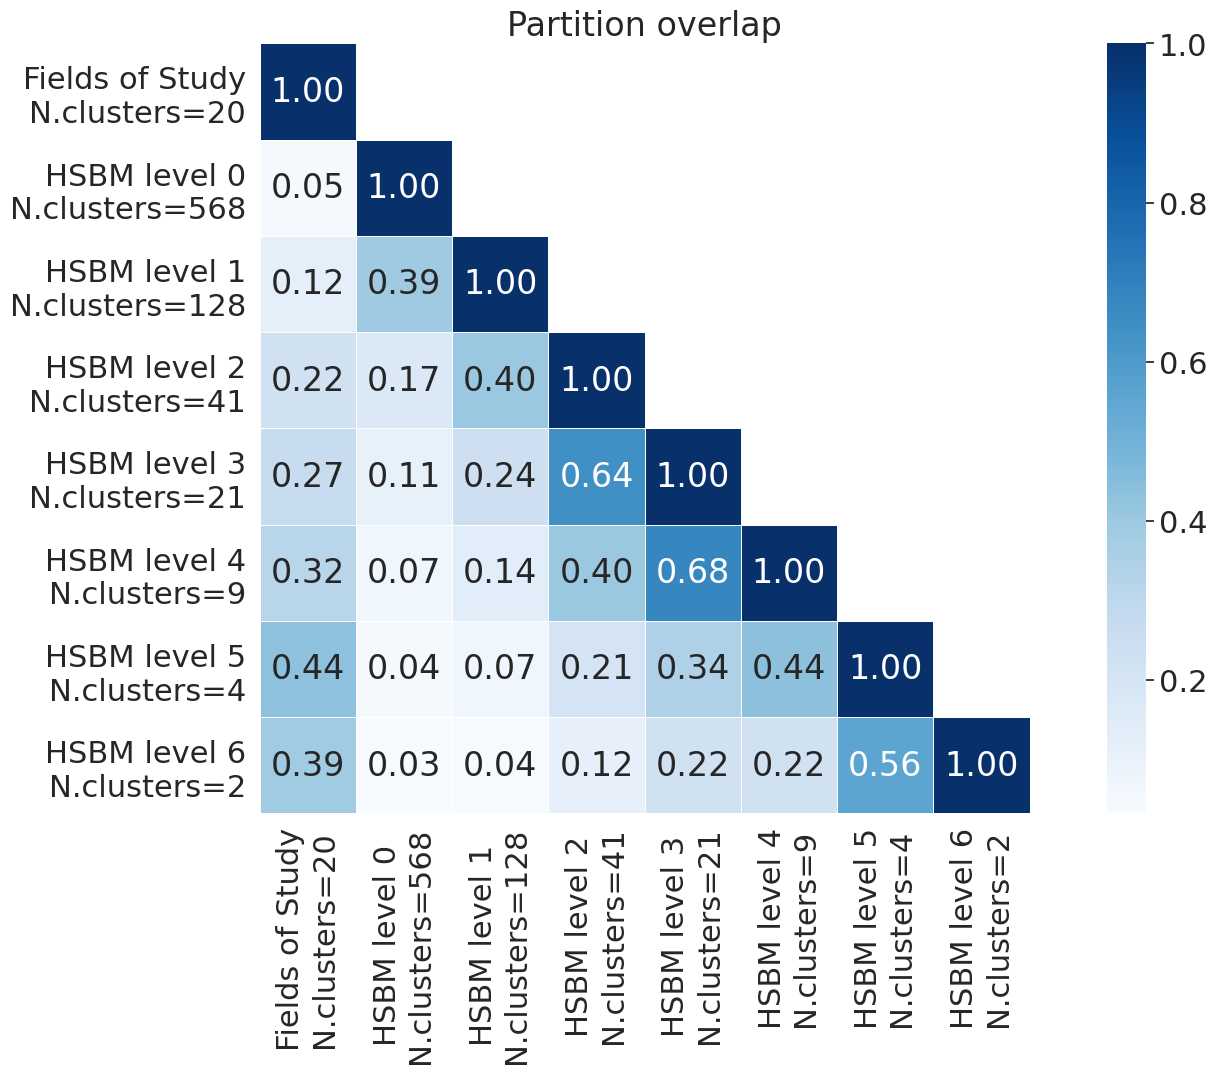

In [37]:
column_names = get_column_names(print_n_clusters = True)
if use_first_only_field == True:
    file_name = f"Partition_overlap_{min_word_occurences}_min_word_occurences_only_first_field"
else:
    file_name = f"Partition_overlap_{min_word_occurences}_min_word_occurences"
if use_titles == 1:
    file_name += "_titles"
file_path_png = paper_figures_folder + file_name + ".png"
file_path_pdf = paper_figures_folder + file_name + ".pdf"
visualise_heatmap_results(max_partition_overlap_avg, max_partition_overlap_std, column_names, 
                          r"Partition overlap", print_std = False,
                         file_path_png=file_path_png, file_path_pdf=file_path_pdf)

In [38]:
# Compute the average partition overlap and standard deviation
nmi_avg, nmi_std = construct_nmi_matrix([[h_t_doc_consensus_by_level[l]] for l in h_t_doc_consensus_by_level.keys()], true_partition_int)

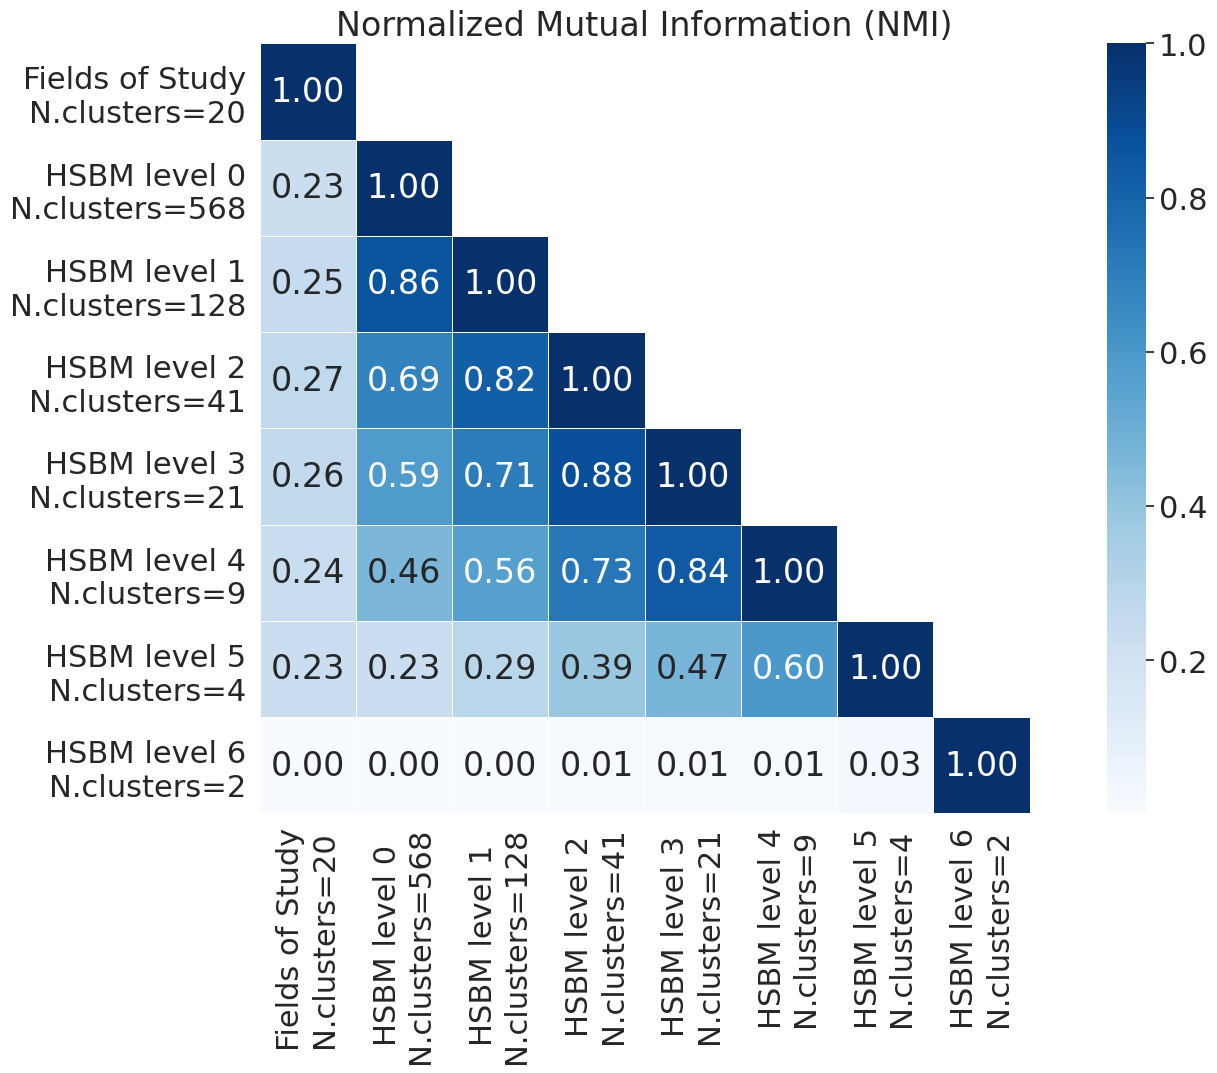

In [39]:
column_names = get_column_names(print_n_clusters = True)
if use_first_only_field == True:
    file_name = f"NMI_{min_word_occurences}_min_word_occurences_only_first_field"
else:
    file_name = f"NMI_{min_word_occurences}_min_word_occurences"
if use_titles == 1:
    file_name += "_titles"
file_path_png = paper_figures_folder + file_name + ".png"
file_path_pdf = paper_figures_folder + file_name + ".pdf"
visualise_heatmap_results(nmi_avg, nmi_std, column_names, r"Normalized Mutual Information (NMI)", print_std = False,
                         file_path_png=file_path_png, file_path_pdf=file_path_pdf)

## Interdisciplinarity from topic trees

In [ ]:
def interdisciplinarity_distance_tree_partition(level_partition, 
                                      partition, 
                                      top_level_topics, 
                                      bottom_level_topics, 
                                      max_num_topics_to_represent,
                                      normalization = ""
                                     ):
    
    if level_partition > max(list(hierarchy_words.keys())):
        level_partition = max(list(hierarchy_words.keys())) + 1
    
    # Let's create a tree undirected network
    G = nx.DiGraph()
    # this is just for drawing
    node_size = {} # key is node name
    edge_size = {} # key is tuple of source,target
    
    # let's find the root at the top_level of topics as the one with highest normalized mixture proportion with the chosen cluster
    root = get_most_represented_topic(level_partition, partition, top_level_topics)
#     print(root)
    root_name = name_node(top_level_topics,root)
    node_size[root_name] = get_mixture_proportion(level_partition, partition, top_level_topics, root)# * multiplicator_size_nodes
    G.add_node(root_name)
    
    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level_topics:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level_topics, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = get_mixture_proportion(level_partition, partition, l-1, child)# * multiplicator_size_nodes
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    
    edge_size_sum = {}
    edge_counter = {}
    node_colors = {}
    for l in range(bottom_level_topics+1,top_level_topics+1):
        # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
        if l-1 == bottom_level_topics:
            leaves = {}
            for i in selected_nodes_by_level[l]:
                m = min(hierarchy_words[l])
                m2 = min(hierarchy_words[l-1])
                # topics at lower level in the hierarchy from the superior node
                children = np.array(list(hierarchy_words[l][i+m])) - m2
                for child in children:
                    child_name = name_node(l-1,child)
#                     if node_size_old[child_name] > 0:
                    leaves[child_name] = node_size_old[child_name]
#             highlighted_leaves = set(pd.Series(leaves).sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            
        
        # Let's add all of these nodes in the Graph, using their new names
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            sum_weights_children = 0
#             sum_weights_children_highlighted = 0
            # Let's add the nodes
            child_names = []
            father_name = name_node(l,i)
#             node_colors[father_name] = cmap(0)
            for child in children:    
                child_name = name_node(l-1,child)
#                      
                child_names.append(child_name)
                sum_weights_children += node_size[child_name]
                G.add_node(child_name)
            
                
            # Let's add the edges
            edge_size_sum[father_name] = 0
            edge_counter[father_name] = 0
            for child_name in child_names:
                if l == bottom_level_topics+1:
                    edge_size[(father_name,child_name)] = node_size[child_name]# * multiplicator_size_edges
                else:
                    edge_size[(father_name,child_name)] = edge_size_sum[child_name] / edge_counter[child_name]
                edge_size_sum[father_name] += edge_size[(father_name,child_name)]
                edge_counter[father_name] += 1
                G.add_edge(father_name,child_name)
            
    spl = dict(nx.all_pairs_shortest_path_length(nx.Graph(G)))
    weighted_distances = []
    weighted_distances_dict = {}
#     return spl,G
    highlighted_leaves_list = list(highlighted_leaves)
    for i,node1 in enumerate(highlighted_leaves_list):
        weighted_distances_dict[node1] = []
        for node2 in highlighted_leaves_list[i+1:]:
            if node1 == node2: # this shouldn't be done
                print("Something's off...")
                continue
            weighted_distances_dict[node1].append(spl[node1][node2]*node_size[node2])
            weighted_distances.append(spl[node1][node2]*node_size[node1]*node_size[node2])
        weighted_distances_dict[node1] = np.sum(weighted_distances_dict[node1])/np.sum([node_size[y] for i,x in enumerate(highlighted_leaves_list) for y in highlighted_leaves_list[i+1:]])
        .append(spl[node1][node2]*node_size[node2])
    
    if len(weighted_distances) == 0:
        return 0,spl,G
    
    weighted_distance = np.sum(weighted_distances)/np.sum([node_size[x]*node_size[y] for i,x in enumerate(highlighted_leaves_list) for y in highlighted_leaves_list[i+1:]])
    
    avg_distance = np.mean([spl[x][y] for x in leaves.index for y in leaves.index if y != x])
    diameter = float(np.max([spl[x][y] for x in leaves.index for y in leaves.index]))
#     print(weighted_distance,diameter)
    if normalization=='avg':
        return (weighted_distance - avg_distance)/avg_distance,spl,G
    elif normalization=='diameter':
        return (weighted_distance)/diameter,spl,G
    elif normalization=='diameter+avg':
        return (weighted_distance - avg_distance)/(diameter - avg_distance),spl,G
    elif normalization=='sum distances':
        leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
        return (weighted_distance - avg_distance)/(diameter - avg_distance),spl,G

In [ ]:
def interdisciplinarity_distance_tree_partition(level_partition, 
                                      partition, 
                                      top_level_topics, 
                                      bottom_level_topics, 
                                      max_num_topics_to_represent,
                                      normalization = "",
                                                threshold = 0
                                     ):
    
    if level_partition > max(list(hierarchy_words.keys())):
        level_partition = max(list(hierarchy_words.keys())) + 1
    
    # Let's create a tree undirected network
    G = nx.DiGraph()
    # this is just for drawing
    node_size = {} # key is node name
    edge_size = {} # key is tuple of source,target
    
    # let's find the root at the top_level of topics as the one with highest normalized mixture proportion with the chosen cluster
    root = get_most_represented_topic(level_partition, partition, top_level_topics)
#     print(root)
    root_name = name_node(top_level_topics,root)
    node_size[root_name] = get_mixture_proportion(level_partition, partition, top_level_topics, root)# * multiplicator_size_nodes
    G.add_node(root_name)
    
    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level_topics:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level_topics, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = get_mixture_proportion(level_partition, partition, l-1, child)# * multiplicator_size_nodes
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    
    edge_size_sum = {}
    edge_counter = {}
    node_colors = {}
    for l in range(bottom_level_topics+1,top_level_topics+1):
        # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
        if l-1 == bottom_level_topics:
            leaves = {}
            for i in selected_nodes_by_level[l]:
                m = min(hierarchy_words[l])
                m2 = min(hierarchy_words[l-1])
                # topics at lower level in the hierarchy from the superior node
                children = np.array(list(hierarchy_words[l][i+m])) - m2
                for child in children:
                    child_name = name_node(l-1,child)
#                     if node_size_old[child_name] > 0:
                    leaves[child_name] = node_size_old[child_name]
#             highlighted_leaves = set(pd.Series(leaves).sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>threshold].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            
        
        # Let's add all of these nodes in the Graph, using their new names
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            sum_weights_children = 0
#             sum_weights_children_highlighted = 0
            # Let's add the nodes
            child_names = []
            father_name = name_node(l,i)
#             node_colors[father_name] = cmap(0)
            for child in children:    
                child_name = name_node(l-1,child)
#                      
                child_names.append(child_name)
                sum_weights_children += node_size[child_name]
                G.add_node(child_name)
            
                
            # Let's add the edges
            edge_size_sum[father_name] = 0
            edge_counter[father_name] = 0
            for child_name in child_names:
                if l == bottom_level_topics+1:
                    edge_size[(father_name,child_name)] = node_size[child_name]# * multiplicator_size_edges
                else:
                    edge_size[(father_name,child_name)] = edge_size_sum[child_name] / edge_counter[child_name]
                edge_size_sum[father_name] += edge_size[(father_name,child_name)]
                edge_counter[father_name] += 1
                G.add_edge(father_name,child_name)
            
    spl = dict(nx.all_pairs_shortest_path_length(nx.Graph(G)))
    weighted_distances = []
    weighted_distances_dict = {}
#     return spl,G
    highlighted_leaves_list = list(highlighted_leaves)
    for i,node1 in enumerate(highlighted_leaves_list):
        weighted_distances_dict[node1] = []
        for node2 in highlighted_leaves_list[i+1:]:
            if node1 == node2: # this shouldn't be done
                print("Something's off...")
                continue
            node_size[node2] = 1
            weighted_distances_dict[node1].append(spl[node1][node2]*node_size[node2]) # ACHTUNG PUT node size = 1 (?)
        weighted_distances_dict[node1] = np.sum(weighted_distances_dict[node1])#/np.sum([node_size[y] for i,x in enumerate(highlighted_leaves_list) for y in highlighted_leaves_list[i+1:]])
    
    max_weighted_distances_dict = {}
#     return spl,G
    highlighted_leaves_list = list(highlighted_leaves)
    for i,node1 in enumerate(leaves.index):
        max_weighted_distances_dict[node1] = []
        for node2 in leaves.index[i+1:]:
            if node1 == node2: # this shouldn't be done
                print("Something's off...")
                continue
            node_size[node2] = 1
            max_weighted_distances_dict[node1].append(spl[node1][node2]*node_size[node2]) # ACHTUNG PUT node size = 1 (?)
        max_weighted_distances_dict[node1] = np.sum(max_weighted_distances_dict[node1])#/np.sum([node_size[y] for i,x in enumerate(leaves.index) for y in leaves.index[i+1:]])
    
    return sum(list(weighted_distances_dict.values()))/sum(list(max_weighted_distances_dict.values())),spl,G
#     if len(weighted_distances) == 0:
#         return 0,spl,G
    
#     weighted_distance = np.sum(weighted_distances)/np.sum([node_size[x]*node_size[y] for i,x in enumerate(highlighted_leaves_list) for y in highlighted_leaves_list[i+1:]])
    
#     avg_distance = np.mean([spl[x][y] for x in leaves.index for y in leaves.index if y != x])
#     diameter = float(np.max([spl[x][y] for x in leaves.index for y in leaves.index]))
# #     print(weighted_distance,diameter)
#     if normalization=='avg':
#         return (weighted_distance - avg_distance)/avg_distance,spl,G
#     elif normalization=='diameter':
#         return (weighted_distance)/diameter,spl,G
#     elif normalization=='diameter+avg':
#         return (weighted_distance - avg_distance)/(diameter - avg_distance),spl,G
#     else:#if normalization=='sum distances':
#         leaves = pd.Series(leaves)
#             highlighted_leaves = set(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
#         return (weighted_distance - avg_distance)/(diameter - avg_distance),spl,G

In [ ]:
def interdisciplinarity_distance_tree(level_partition, 
                                      top_level_topics, 
                                      bottom_level_topics, 
                                      max_num_topics_to_represent,
                                      threshold_num_papers = 100,
                                      normalization = ""
                                     ):
    
    interdisciplinarity = {}
    for partition in hierarchy_docs[level_partition].keys():
        interdisciplinarity[partition] = interdisciplinarity_distance_tree_partition(level_partition, partition, top_level_topics, bottom_level_topics, max_num_topics_to_represent,normalization=normalization)[0]
        
    interdisciplinarity = {x:y for x,y in interdisciplinarity.items() if len([t for t in name2partition_by_level[level_partition].keys() if name2partition_by_level[level_partition][t]==x]) > threshold_num_papers}
    M = max(interdisciplinarity.values())
    normalized_interdisciplinarity = {x:y/M for x,y in interdisciplinarity.items()}
    
    return normalized_interdisciplinarity,interdisciplinarity

### Average distance

In [ ]:
l = 5
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=5,threshold_num_papers=1000,normalization="avg")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
l = 4
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=5,threshold_num_papers=1000,normalization="avg")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
l = 3
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=5,threshold_num_papers=1000,normalization="avg")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

### Diameter

In [ ]:
l = 5
                                        # level_partition, 
#                                       top_level_topics, 
#                                       bottom_level_topics, 
#                                       max_num_topics_to_represent,
#                                       threshold_num_papers = 100,
#                                       normalization = ""
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=100,threshold_num_papers=1000,normalization="")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
l = 4
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=100,threshold_num_papers=1000,normalization="")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
l = 3
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=100,threshold_num_papers=1000,normalization="")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
l = 2
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=100,threshold_num_papers=1000,normalization="")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
fig,ax = plt.subplots(1,1)
create_hierarchy_network(2,23,6,2,10,10,ax)

# Roadmap

1. ~hierarchy definition of topics -> look at top words (use score?) --- add manual label --- layer 4 to 2~
2. coherence between clusters and fields - which fields (and in which percentage) in each cluster (and time distribution in cluster) --> interdisciplinary clusters? how do they talk (cits or topics)?
3. ~topic vs cluster -> look at matrix to define what the cluster talk about (manual annotation? need lower level hierarchy?)~
4. merge 1to3 to produce cool figure like science advances (primo paper di Peixoto su sta roba https://www.science.org/doi/10.1126/sciadv.aaq1360)
5. for each cluster -> look at articles to understand how they define decentralization -> decide how to sample articles (best paper for each metric)
6. is the definition of decentralization coherent across sub-cluster in the hierarchy?
7. Random stuff:
    - word2vec + umap: should we compare to hsbm? use it in SI (?)

## Interdisciplinarity
- Prendi i primi 5 o 10 topics di un cluster di livello 2 o 3 con almeno 5 parole e mixture proportion > threshold (0 o 1).
- Interdisciplinarity come media tra le distanze tra tutte le coppie di topics (selezionati) pesati con il prodotto tra le due normalized mixture proportions di ciascuna coppia. 

COME CALCOLARE INTERDISCIPLINARIETA' IN CLUSTER
1. Clippare sopra 10 (o altro numero che sia) tutte le normalized mixture proportion
1. Sommare 1? Per capire nella media quanti topic ci sono
    1. Oppure no, si possono clippare tutti quelli minori di 0 a 0
1. Dividere per il massimo delle normalized mixture proportion
1. Sommare new peso1 * new peso2 * distanza tra i due cluster (oppure aggiungere un numero per singolo nodo, mediando su nodo2)
1. Dividere per interdisciplinarieta' massima, che si ha quando le normalized mixture proportions sono a 1 (distanza media per numero di link)
1. FORSE SI PUO' FARE ANCHE LA MEDIA DIRETTAMENTE (ma forse dividere per il massimo e' meglio)

## TODO
- Colorbar hierarchy networks (entrambi)
- Aggiungere citazioni a partire da cluster 8 lev 3 (fatto cluster 10 lev 3 cluster 15 lev 2)

WHAT WE HAVE DONE
1. Decentralization increasing over time
1. Fields di Scholar: non funzionano bene, ovvero non sono dettagliati!
1. Utilizziamo hSBM per fare topic modelling e articles clusterization gerarchico
    1. Guardiamo struttura gerarchica (plot gerarchico e plot docs clusterizzati): fighi, ma solo per la loro fighezza
    1. Capiamoci di piu: guardiamo clusters a level 2 e li caratterizziamo in base ai topic rappresentati 
    1. Guardando i clusters, abbiamo selezionato dei paper rappresentativi
1. Abbiamo definito e calcolato il knowledge flow tra i vari cluster e di anno in anno

WHAT WE WANT TO DO
Vogliamo capire come il concetto di decentralization si e' evoluto nel tempo e across fields
1. Sistemare questi notebooks, mettendo funzioni in altri script e ripulendo tutto.
1. Capire come i vari cluster parlano dei vari fields (aiuta a dire che i vari cluster in realta' differiscono dai singoli fields, cioe piu fields contribuiscono a formare un cluster che parla di un argomento specifico)
    1. Fare network bipartito da un lato fields, dall'altro cluster (il barplot con i fields diventano i pesi dei link), eventualmente da fare nel tempo (tipo a 10 anni a 10 anni)
    1. Oppure farlo con una heatmap, ma bisogna sacrificare una dimensione purtroppo (tra cluster, field, tempo, e numero di papers che rappresenti col colore) **MEGLIO!!!**
        1. ~e.g. fields nel tempo per un singolo cluster **(CAMBIARLO NELLA FIG BARPLOT)**~
        1. ~**o clusters nel tempo per un singolo field** (COPIARE TICKS A SX E DX)~
        1. ~**o cluster nei fields in un periodo di tempo (questo e' la cosa piu' utile per ora probabilmente)**~
            - ~**_TODO_ CAMBIARE ORDINE DEI CLUSTER CON L'ORDINE USATO PER FARE I PLOT DI CLUSTER GERARCHICI**~
            - Sistemarli anche nella figura del network bipartito e aggiungere i nuovi labels dei topics
    1. ~**Ripetere non solo non num_of_papers ma anche con knowledge flow vs others, oppure  knowledge flow vs se stesso, oppure knowledge flow uscente totale (verso il futuro)**~
        - ~Sarebbe figo farlo con il network gerarchico dei clusters a sx che si allinea perfettamente con l'heatmap, e magari si scelgono solo le parole chiave (2 o 3) dei cluster di livello 3 e si printano solo quelli (FARE SOLTANTO SE ANDRA' NEL MAIN)~
    1. ~Provare la heatmap per fare il plot con tutte le subfig, ciascuna che conta anno per anno quanti cluster hanno knowledge flow > threshold.~
    1. ~Provare la heatmap per fare il plot con tutte le subfig che selezionano le coppie di cluster con spikes nel knowledge flow nel tempo~
    1. Unire alla differenziazione dei cluster nei vari fields, anche l'interdisciplinarieta' di ciascun cluster tramite i topic (magari usando una forma di entropia gerarchica o l'average distance o qualcosa di additivo che tiene conto della gerarchia)
1. Capire la storia di ciascun cluster
    1. Usare quanti paper ci sono stati in ciascun anno in ciascun field/cluster e i knowledge flow.
    1. ~**VEDI PRIMA**: heatmap con gli anni nella x, i vari cluster (lev 2 o 3 o fieldsOfStudy) nella y ordinati con la gerarchia. Coloriamo in base al numero di papers di quel cluster in quell'anno, oppure knowledge flow vs others, oppure  knowledge flow vs se stesso, oppure knowledge flow uscente totale (verso il futuro)~
        - ACHTUNG: Questo ci dice soltanto come si sono evoluti i topics che parlano di decentralization, ma non come ne parlano. Si spera che la storia ci dica qualcosa di interessante, e poi si vedono solo quei papers
1. ~Usare i knowledge flows per individuare spikes nel tempo/across fields per capire i vari influenzamenti che ci sono stati nella letteratura di decentralization~
    1. ~**_TODO_ Individuare tutti gli spike nei knowledge flow nel tempo tra due qualsiasi clusters, e plottarli in un modo intelligente (per ora ci teniamo i subplots solo di questi)**~
    1. ~**_TODO_ Studiare la storia dei knowledge flow a partire da un unico cluster per studiare il singolo cluster nel tempo**~
1. Capirci ancora meglio guardando alcuni dei papers relativi a queste spike (?)
1. Nella storia da raccontare, prestare attenzione a temi attuali e dare una spiegazione semi-scientifica dai dati e dal metodo che abbiamo, per dire come si e' arrivati a parlare di decentralization in quei termini in questo periodo in questi cluster (e.g. blockchain/iot/defi, ma anche governance/economics)
1. Capire a che journal mandare sto cavolo di paper xD
1. Scrivere il paper